Le but de se projet est de pricer des options de types Best of ou Worst of sur un panier de deux sous-jacents puisque l'on a une formule simple pour pricer les WO call

WOpayoff =$max(0, min(S1(T),S2(T),....,Sn(T)))$
pour n actifs ici on considèrera seulement 2 actifs

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def WOcall(S1,S2,K,T,r,sigma1,sigma2,correl):
  """
    Calcule le prix d'une option worst‐of call sur deux actifs selon une formule d'approximation.
    pour ce simplifier la vie on ne considère qu'il n'y a pas de dividendes, une autre formule existe pour le cas avec dividendes

    Paramètres :
      S1, S2 : Prix actuels des deux actifs
      K      : Strike de l'option
      T      : Temps à l'échéance (en années)
      r      : Taux d'intérêt sans risque
      sigma1, sigma2 : Volatilités des deux actifs
      rho    : Coefficient de corrélation entre les deux actifs

    Retourne :
      Le prix de l'option worst-of call.
    """

  gamma1= ( np.log( S1/K )+( r - ( sigma1**2 )/2)*T )/(sigma1*np.sqrt(T))  #d1,1

  gamma2= ( np.log( S2/K )+(r - ( sigma2**2 )/2)*T )/(sigma2*np.sqrt(T))  #d1,2

  sigma= np.sqrt(sigma1**2 + sigma2**2 -2*correl*sigma1*sigma2)

  # Corrélations ajustées
  rho1 = (correl * sigma1 - sigma2) / sigma

  rho2 = (correl * sigma2 - sigma1) / sigma
  #elements nécéssaire pour utilisert la fonction multivariate_normal.cdf de scipy
  mean = [0, 0]    #pour loi centrée réduite

  cov1=[[1, rho1], [rho1, 1]]    #matrice de covariance
  point1 = [gamma1 + sigma1 * np.sqrt(T), (np.log(S2/S1) - 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))]
  Phi2_d1 = multivariate_normal.cdf(point1, mean, cov1)

  cov2=[[1, rho2], [rho2, 1]]    #matrice de covariance
  point2 = [gamma2 + sigma2 * np.sqrt(T), (np.log(S1/S2) - 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))]
  Phi2_d2 = multivariate_normal.cdf(point2, mean, cov2)

  point3= [gamma1,gamma2]                                                #calcul troisième terme
  Phi_d3 = multivariate_normal.cdf(point3, mean, cov=[[1,correl],[correl,1]])


  price = (S1  * Phi2_d1 +
             S2  * Phi2_d2 -
             K * np.exp(-r * T) * Phi_d3)
  return(price)

S1 = 100.0       # Prix du premier actif
S2 = 100.0        # Prix du second actif
K = 90.0         # Strike
T = 1.0          # 1 an jusqu'à l'échéance
r = 0.05         # Taux d'intérêt sans risque de 5%
sigma1 = 0.20    # Volatilité 20% pour le premier actif
sigma2 = 0.25    # Volatilité 25% pour le second actif
rho = 0.5        # Corrélation de 0.5 entre les deux actifs

price = WOcall(S1, S2, K, T, r, sigma1, sigma2, rho)
print("Le prix de l'option worst-of call est : {:.4f}".format(price))




Le prix de l'option worst-of call est : 10.7668


faisons maintenat un peu de graphique pour mieux ce représenter l'évolution de notre payoff la seule difficulté ici est de ne pas oublier de corrélé nos mouvements browniens géométrique

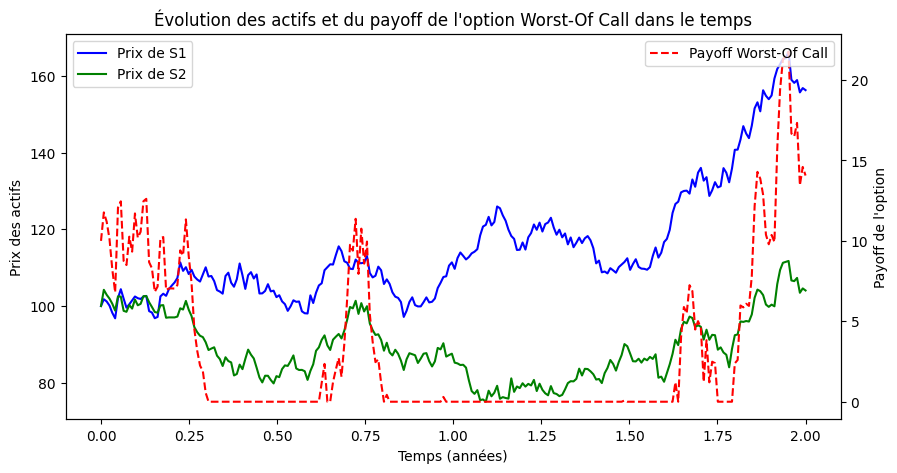

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de simulation
T = 2.0           # 1 an
N = 250           # Nombre de pas de temps
dt = T / N        # Pas de temps
r = 0.05          # Taux d'intérêt sans risque
sigma1 = 0.2      # Volatilité de S1
sigma2 = 0.25     # Volatilité de S2
rho = 0.5         # Corrélation entre S1 et S2
S1_0 = 100        # Prix initial de S1
S2_0 = 100        # Prix initial de S2
K = 90            # Strike

# Simulation des trajectoires de S1 et S2 corrélé
W1 = np.random.randn(N) * np.sqrt(dt)
W2 = rho * W1 + np.sqrt(1 - rho**2) * np.random.randn(N) * np.sqrt(dt)

S1 = np.zeros(N)
S2 = np.zeros(N)
S1[0] = S1_0
S2[0] = S2_0
for t in range(1, N):
    S1[t] = S1[t-1] * np.exp((r - 0.5 * sigma1**2) * dt + sigma1 * W1[t])
    S2[t] = S2[t-1] * np.exp((r - 0.5 * sigma2**2) * dt + sigma2 * W2[t])




payoff = np.maximum(np.minimum(S1, S2) - K, 0)

# Tracé des graphiques
fig, ax1 = plt.subplots(figsize=(10, 5))

# Tracé des prix des actifs
ax1.plot(np.linspace(0, T, N), S1, label="Prix de S1", color="blue")
ax1.plot(np.linspace(0, T, N), S2, label="Prix de S2", color="green")
ax1.set_ylabel("Prix des actifs")
ax1.set_xlabel("Temps (années)")
ax1.legend(loc="upper left")

# Deuxième axe pour le payoff
ax2 = ax1.twinx()
ax2.plot(np.linspace(0, T, N), payoff, label="Payoff Worst-Of Call", color="red", linestyle="dashed")
ax2.set_ylabel("Payoff de l'option")
ax2.legend(loc="upper right")

plt.title("Évolution des actifs et du payoff de l'option Worst-Of Call dans le temps")
plt.show()



passons maintenant au pricing par méthode de monte-carlo

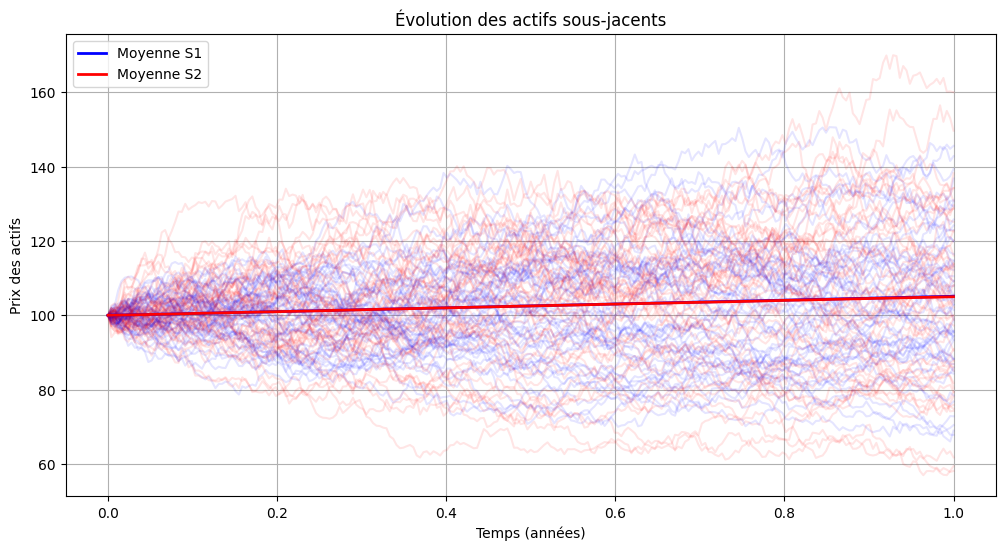

Prix estimé du Worst-Of Call (Monte Carlo) : 10.2029


In [38]:
import numpy as np
import matplotlib.pyplot as plt

def simulation_WOCall_MC(S1, S2, K, T, r, sigma1, sigma2, rho, N_sim, N_pas):
    """
    Simule le Worst-Of Call avec affichage des trajectoires

    Paramètres :
    - S1, S2 : Prix initiaux des actifs
    - K : Strike
    - T : Maturité
    - r : Taux sans risque
    - sigma1, sigma2 : Volatilités des actifs
    - rho : Corrélation entre S1 et S2
    - N_sim : Nombre de simulations Monte Carlo
    - N_pas : Nombre de pas de temps pour la simulation

    Retourne :
    - Prix estimé de l'option
    """
    np.random.seed(42)  # Reproductibilité

    dt = T / N_pas  # Pas de temps

    # Matrices pour stocker les trajectoires
    S1_paths = np.zeros((N_sim, N_pas + 1))
    S2_paths = np.zeros((N_sim, N_pas + 1))

    # Conditions initiales
    S1_paths[:, 0] = S1
    S2_paths[:, 0] = S2

    for t in range(1, N_pas + 1):
        # Génération des variables gaussiennes corrélées
        W1 = np.random.randn(N_sim)
        W2 = rho * W1 + np.sqrt(1 - rho**2) * np.random.randn(N_sim)
        S1_paths[:, t] = S1_paths[:, t - 1] * np.exp((r - 0.5 * sigma1**2) * dt + sigma1 * np.sqrt(dt) * W1)
        S2_paths[:, t] = S2_paths[:, t - 1] * np.exp((r - 0.5 * sigma2**2) * dt + sigma2 * np.sqrt(dt) * W2)


    payoff = np.maximum(np.minimum(S1_paths[:, -1], S2_paths[:, -1]) - K, 0)
    price = np.exp(-r * T) * np.mean(payoff)

    # Affichage des courbes
    time_grid = np.linspace(0, T, N_pas + 1)
    plt.figure(figsize=(12, 6))
    for i in range(50):  # Affichage de 50 trajectoires aléatoires pour une meilleure lisibilité
        plt.plot(time_grid, S1_paths[i, :], color='blue', alpha=0.1)
        plt.plot(time_grid, S2_paths[i, :], color='red', alpha=0.1)

    plt.plot(time_grid, np.mean(S1_paths, axis=0), color='blue', linewidth=2, label="Moyenne S1")
    plt.plot(time_grid, np.mean(S2_paths, axis=0), color='red', linewidth=2, label="Moyenne S2")

    plt.xlabel("Temps (années)")
    plt.ylabel("Prix des actifs")
    plt.title("Évolution des actifs sous-jacents")
    plt.legend()
    plt.grid()
    plt.show()

    return price

# Paramètres
S1 = 100.0
S2 = 100.0
K = 90.0
T = 1.0
r = 0.05
sigma1 = 0.20
sigma2 = 0.25
rho = 0.5
N_sim = 100000
N_pas = 252   # 252 jours ouvert

# Calcul et affichage
mc_price = simulation_WOCall_MC(S1, S2, K, T, r, sigma1, sigma2, rho, N_sim, N_pas)
print("Prix estimé du Worst-Of Call (Monte Carlo) : {:.4f}".format(mc_price))
